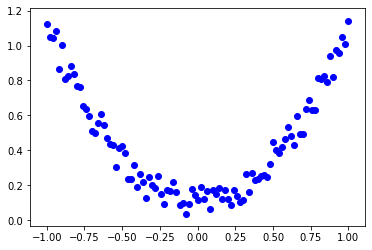

RuntimeError: DataLoader worker (pid(s) 16608, 6396, 7220, 1340, 6444, 12624) exited unexpectedly

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
%matplotlib inline


class Dataset(data.Dataset):
    def __init__(self, start, end, num, f):
        super(Dataset, self).__init__()
        self.num = num
        self.x = torch.linspace(start, end, num)
        self.y = f(self.x)
        plt.scatter(torch.unsqueeze(self.x, dim=1).cpu().numpy(), torch.unsqueeze(self.y, dim=1).cpu().numpy(), c='b')
        plt.show()

    def __getitem__(self, item):
        return self.x[item], self.y[item]

    def __len__(self):
        return self.num


class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        self.linear = nn.Linear(n_input, 10)
        self.relu = F.relu
        self.output = nn.Linear(10, n_output)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.output(x)
        return x


start = -1.
end = 1.
num = 101
f = lambda x: x.pow(2) + 0.2 * torch.rand(x.shape)

dataset = Dataset(start=start, end=end, num=num, f=f)

data_loader = data.DataLoader(dataset=dataset, batch_size=101, shuffle=False, num_workers=6)

net = Net(n_input=1, n_output=1).cuda()

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_function = nn.MSELoss()

losses = []

for epoch in range(200):
    for _, train_data in enumerate(data_loader):
        x = torch.unsqueeze(train_data[0], dim=1).cuda()
        y = torch.unsqueeze(train_data[1], dim=1).cuda()

        pred = net(x)

        loss = loss_function(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)

        if epoch % 10 == 0:
            plt.scatter(torch.unsqueeze(train_data[0], dim=1).cpu().numpy(),
                        torch.unsqueeze(train_data[1], dim=1).cpu().numpy(), c='b')

    if epoch % 10 == 0:
        x = torch.unsqueeze(torch.linspace(start, end, num), dim=1).cuda()
        pred = net(x)
        plt.plot(torch.squeeze(x, dim=1).cpu().numpy(), torch.squeeze(pred, dim=1).cpu().detach().numpy(), 'r-', lw=2)
        plt.show()

for _, train_data in enumerate(data_loader):
    plt.scatter(torch.unsqueeze(train_data[0], dim=1).cpu().numpy(),
                torch.unsqueeze(train_data[1], dim=1).cpu().numpy(), c='b')

x = torch.unsqueeze(torch.linspace(start, end, num), dim=1).cuda()
pred = net(x)
plt.plot(torch.squeeze(x, dim=1).cpu().numpy(), torch.squeeze(pred, dim=1).cpu().detach().numpy(), 'r-', lw=2)
plt.show()

batch_nums = range(1, len(losses) + 1)
plt.plot(batch_nums, losses)
plt.title('Loss - Batch')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()